In [1]:
import pennylane as qml
from pennylane import numpy as npp
from matplotlib import pyplot as plt

# set the random seed
npp.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params,inputs):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.RY(inputs[2], wires=2)
    qml.RY(inputs[3], wires=3)
    

    qml.U3(params[0],params[1],params[2], wires=0)
    qml.U3(params[3],params[4],params[5], wires=1)
    qml.U3(params[6],params[7],params[8], wires=2)
    qml.U3(params[9],params[10],params[11], wires=3)
    

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    qml.RY(inputs[0]*1.5, wires=0)
    qml.RY(inputs[1]*1.5, wires=1)
    qml.RY(inputs[2]*1.5, wires=2)
    qml.RY(inputs[3]*1.5, wires=3)

    qml.U3(params[12],params[13],params[14], wires=0)
    qml.U3(params[15],params[16],params[17], wires=1)
    qml.U3(params[18],params[19],params[20], wires=2)
    qml.U3(params[21],params[22],params[23], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)

    qml.U3(params[24],params[25],params[26], wires=0)
    qml.U3(params[27],params[28],params[29], wires=1)
    qml.U3(params[30],params[31],params[32], wires=2)
    qml.U3(params[33],params[34],params[35], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)
    
    qml.U3(params[36],params[37],params[38], wires=0)
    qml.U3(params[39],params[40],params[41], wires=1)
    qml.U3(params[42],params[43],params[44], wires=2)
    qml.U3(params[45],params[46],params[47], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    #return qml.expval(qml.PauliX(0) @ qml.PauliI(1)@ qml.PauliY(2)@ qml.PauliI(3))
    return qml.expval(qml.PauliX(0) @  qml.PauliY(2))

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math

def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 

maturity time  range:
0.500695213053119 0.59856504541106
Stock price  range:
1.050253079192311 1.0995026925052132
interest rate  range:
0.030719674431487792 0.07952525710003366
option value  range:
0.14409674907741787 0.2655038418773377
sigma range:
0.30220884684944094 0.6947547746402069
(100, 4)
maturity time  range:
0.500695213053119 0.59856504541106
Stock price  range:
1.050253079192311 1.0995026925052132
interest rate  range:
0.030719674431487792 0.07952525710003366
time option-value  range:
-3.0805231504724975 -1.7390184777930167
sigma range:
0.30220884684944094 0.6947547746402069
(80, 4)
Parameters: [0.10312387 0.90255291 0.50525237 0.82645747 0.3200496  0.89552323
 0.38920168 0.01083765 0.90538198 0.09128668 0.31931364 0.95006197
 0.95060715 0.57343789 0.63183721 0.44844552 0.29321077 0.32866455
 0.67251846 0.75237453 0.79157904 0.78961814 0.0912061  0.4944203
 0.05755876 0.54952888 0.4415305  0.88770418 0.35091501 0.11706702
 0.14299168 0.76151063 0.61821806 0.10112268 0.084106

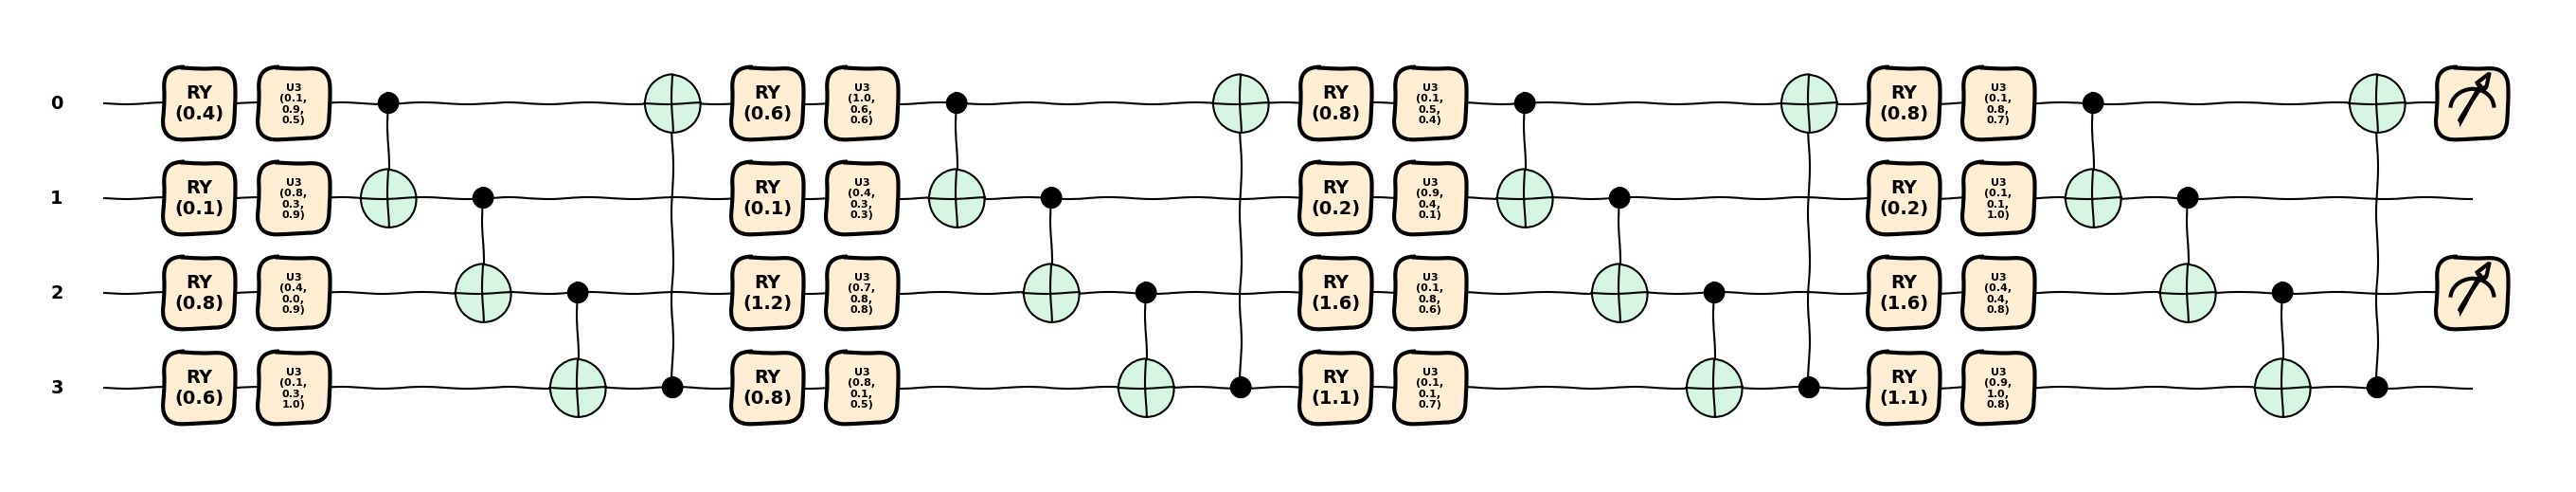

In [3]:
Xin_input,Yin_output=bsm_iv_generator(num_sample = 100,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[1.05,1.1], rr_bound=[0.03,0.08],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2
xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log))


params = npp.random.random([48], requires_grad=True)
inputs = npp.random.random([4], requires_grad=True)
print("Parameters:", params)
print("inputs:", inputs)
print("Expectation value:", circuit(params,inputs))


qnode = qml.QNode(circuit, dev)
qml.draw_mpl(circuit, decimals=1, style="sketch")(params,inputs)
plt.show()

In [4]:
def parameter_shift_term(qnode,params,inputs, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted,inputs)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted,inputs) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit,params,inputs, 0))


def parameter_shift(qnode, params,inputs):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode,params,inputs, i)

    return gradients

print(parameter_shift(circuit, params,inputs))

grad_function = qml.grad(circuit)
print(grad_function(params,inputs)[0])


print(qml.gradients.param_shift(circuit)(params,inputs)[0])

-0.3374912612020583
[-0.33749126 -0.09915668 -0.06185125 -0.26910104  0.05891374  0.02076931
  0.01797391  0.14212672  0.08608545  0.15779852 -0.07372197 -0.07526997
  0.14275668 -0.28205154 -0.11986809 -0.28871775 -0.05421361 -0.08793581
 -0.11871365  0.17172851  0.22470629  0.0043286   0.06745793  0.00287345
  0.33011744 -0.26040615 -0.27560768 -0.19834688  0.12823259  0.05837369
  0.06733227  0.15334914  0.13782826 -0.24941613 -0.03208555 -0.0158946
 -0.09744885  0.09029743  0.09664425  0.00905494 -0.09454985 -0.10288934
  0.07005293  0.34227509  0.25267564 -0.02163458  0.20453716  0.09290435]
[-0.33749126 -0.09915668 -0.06185125 -0.26910104  0.05891374  0.02076931
  0.01797391  0.14212672  0.08608545  0.15779852 -0.07372197 -0.07526997
  0.14275668 -0.28205154 -0.11986809 -0.28871775 -0.05421361 -0.08793581
 -0.11871365  0.17172851  0.22470629  0.0043286   0.06745793  0.00287345
  0.33011744 -0.26040615 -0.27560768 -0.19834688  0.12823259  0.05837369
  0.06733227  0.15334914  0.137

In [5]:
from sklearn import metrics
from itertools import chain
import time
def QNN(weights, angles):
    return circuit(weights, angles)

def cost(weights, features, labels):
    predictions = [QNN(weights, f) for f in features]
    
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def R2(labels, predictions):

    r2 = 0
    for l, p in zip(labels, predictions):
        r2 = r2 + metrics.r2_score(labels, predictions)
    r2 = r2 / len(labels)

    return r2

In [6]:
X=xtv_train_log
Y=ytv_train_log
weights_init = npp.random.random([48], requires_grad=True)
opt = qml.AdamOptimizer(0.01)
batch_size = 20
batches = len (X) // batch_size
X_batches = npp.array_split(npp.arange(len(X)) , batches)


epoch 1
-------------------------------
batch_idx: 0 loss: 0.02124782898016847 R2: -0.42274300871038406 time: 1704326871.41883
batch_idx: 1 loss: 0.014153499088284472 R2: 0.02032319655940773 time: 1704326902.8185036
batch_idx: 2 loss: 0.009205544456501975 R2: 0.314779997345673 time: 1704326933.4486718
batch_idx: 3 loss: 0.0043338179093394685 R2: 0.5000364610534328 time: 1704326965.3947468
Training [0%] Loss: 0.012235172608573597 time: 1704326965.3947468
weight: [0.14124226 0.9412603  0.54385612 0.78995627 0.3591377  0.93450432
 0.39797527 0.001997   0.87172876 0.08756054 0.35480861 0.98583201
 0.95184203 0.61137108 0.59430582 0.48668252 0.29406857 0.33161502
 0.63493449 0.72515487 0.82597385 0.82531189 0.05933435 0.45873645
 0.019718   0.58765309 0.47959814 0.91890263 0.38730818 0.15088915
 0.10387482 0.78904565 0.64140112 0.12066797 0.11966404 0.73694102
 0.03533002 0.79470455 0.67980724 0.04238204 0.12137887 1.02334745
 0.38936198 0.3314152  0.77453899 0.90826656 0.95035477 0.7162532

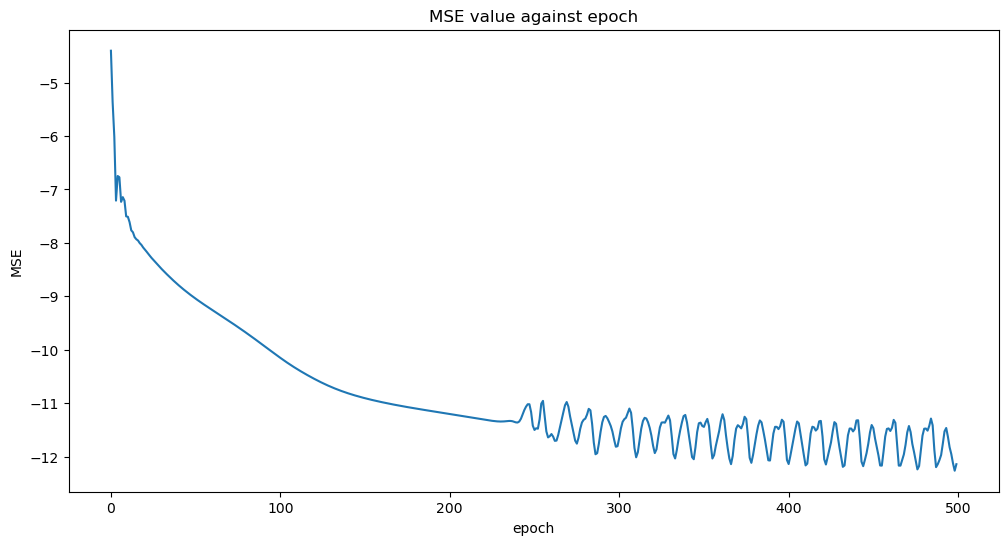

In [7]:
'''
weights =[0.5457064 ,  0.51684106 , 0.49625874,  0.39101955,  0.74559543 , 0.1459648,
  0.36696254,  0.25894846, -0.7580004 ,  0.25798595,  0.39087119,  0.61178083,
  0.42384127,  0.26783496,  0.72425775,  0.05129447 , 0.36118039,  0.81391338,
  0.93639227 , 0.84345717,  0.78550619,  0.14734554 , 0.14558376,  0.58656473,
  0.10858613 , 0.28848394,  1.00872981,  0.35479373 , 1.08242306 , 0.71641846,
  0.75891862,  0.32926841,  0.49615876,  0.43064778 , 0.31366837 , 0.58395333,
  0.66861594, 0.15167445,  0.72917046,  0.02805156 , 0.87322518,  0.91568968,
  0.74873953,  0.33566232,  0.13931622,  1.92704005 , 0.43684662 , 1.14927725]
weights = npp.array(weights, requires_grad=True)
'''
weights = params
loss_list=[]
r2_list=[]

n_epochs=500

start_time=time.time()
for epoch in range(n_epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for it, batch_index in enumerate (chain(*[X_batches])):
        # Update the weights by one optimizer step
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

        # Compute accuracy
        predictions = [QNN(weights, x) for x in X]
        r2 = R2(Y, predictions)
        cost_t=cost(weights,X_batch,Y_batch)
        total_loss.append(cost_t)
        total_r2.append(r2)
        end_timet=time.time()
        print("batch_idx:",it,"loss:",cost_t,"R2:",r2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]'.format(100. * (epoch + 1) / n_epochs),"Loss:", loss_list[-1], "time:",end_timet)
    print("weight:",weights)
    
    
predictions = [QNN(weights, x) for x in X]

train_R2 = R2(Y, predictions)
train_MSE=metrics.mean_squared_error(Y,predictions)
train_RMSE=train_MSE**(1/2)
train_MAE=metrics.mean_absolute_error(Y,predictions)
train_MAPE=metrics.mean_absolute_percentage_error(Y,predictions)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()

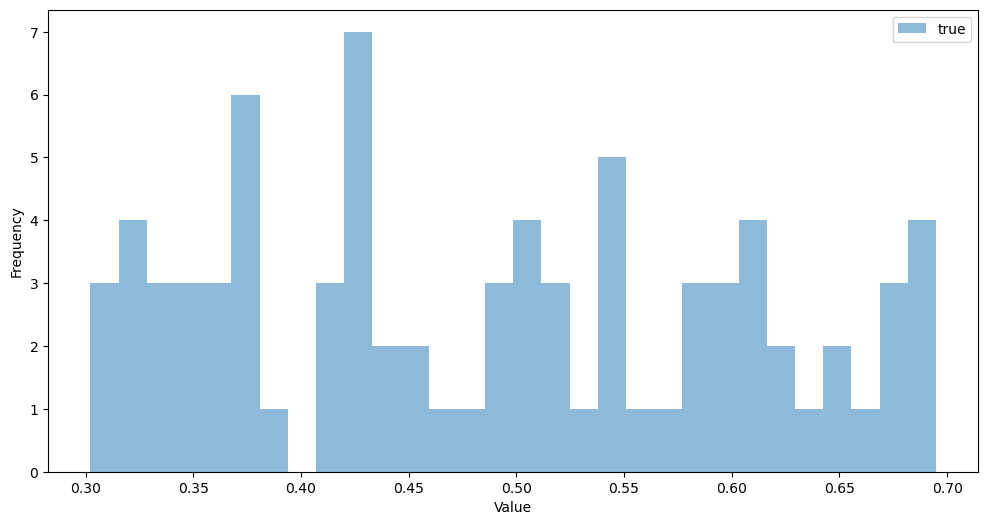

In [8]:
## plt.hist(predictions, bins=30, alpha=0.5, label='predict')
plt.hist(Y, bins=30, alpha=0.5, label='true')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [9]:
print(predictions)
print(Y)

[array(0.67021763), array(0.65589611), array(0.37764932), array(0.3121453), array(0.69616081), array(0.37087536), array(0.34657582), array(0.51131858), array(0.58748275), array(0.29881347), array(0.68734038), array(0.50743968), array(0.43008038), array(0.53606667), array(0.5230298), array(0.361535), array(0.35622919), array(0.51747292), array(0.62735309), array(0.42299683), array(0.37291916), array(0.68709518), array(0.6497002), array(0.50039287), array(0.50348625), array(0.41625475), array(0.55030106), array(0.61531451), array(0.63688709), array(0.38196856), array(0.48436948), array(0.54172081), array(0.50918879), array(0.5756113), array(0.53953384), array(0.44579266), array(0.32497478), array(0.40953437), array(0.42344893), array(0.49216035), array(0.33159196), array(0.33997572), array(0.53920222), array(0.66826624), array(0.68625561), array(0.62055941), array(0.42696034), array(0.33102307), array(0.40830721), array(0.46887569), array(0.34503034), array(0.50004145), array(0.31373106)

In [10]:
X_test=xtv_test_log
Y_test=ytv_test_log
test_predictions = [QNN(weights, x) for x in X_test]

test_R2 = R2(Y_test, test_predictions)
test_MSE=metrics.mean_squared_error(Y_test,test_predictions)
test_RMSE=test_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(Y_test,test_predictions)
test_MAPE=metrics.mean_absolute_percentage_error(Y_test,test_predictions)

print("train_MSE:",test_MSE)
print("train_RMSE:",test_RMSE)
print("train_MAE:",test_MAE)
print("train_MAPE:",test_MAPE)
print("train_R2:",test_R2)

train_MSE: 8.282912819568435e-06
train_RMSE: 0.0028780050068699385
train_MAE: 0.0023008117001099364
train_MAPE: 0.004593759053029346
train_R2: 0.9994756060271118


In [11]:
X1,Y1=bsm_iv_generator(num_sample = 5000,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[1.05,1.1], rr_bound=[0.03,0.08],callput='call')
X1,Y1=logscale_vol(X1,Y1,otm_lower=1e-4)

In [12]:

test1_predictions = [QNN(weights, x) for x in X1]

test1_R2 = R2(Y1, test1_predictions)
test1_MSE=metrics.mean_squared_error(Y1,test1_predictions)
test1_RMSE=test1_MSE**(1/2)
test1_MAE=metrics.mean_absolute_error(Y1,test1_predictions)
test1_MAPE=metrics.mean_absolute_percentage_error(Y1,test1_predictions)

print("train_MSE:",test1_MSE)
print("train_RMSE:",test1_RMSE)
print("train_MAE:",test1_MAE)
print("train_MAPE:",test1_MAPE)
print("train_R2:",test1_R2)

train_MSE: 1.0976650805501646e-05
train_RMSE: 0.003313102896908221
train_MAE: 0.0022195922242021185
train_MAPE: 0.004659354745822888
train_R2: 0.9991820275145016


<function matplotlib.pyplot.show(close=None, block=None)>

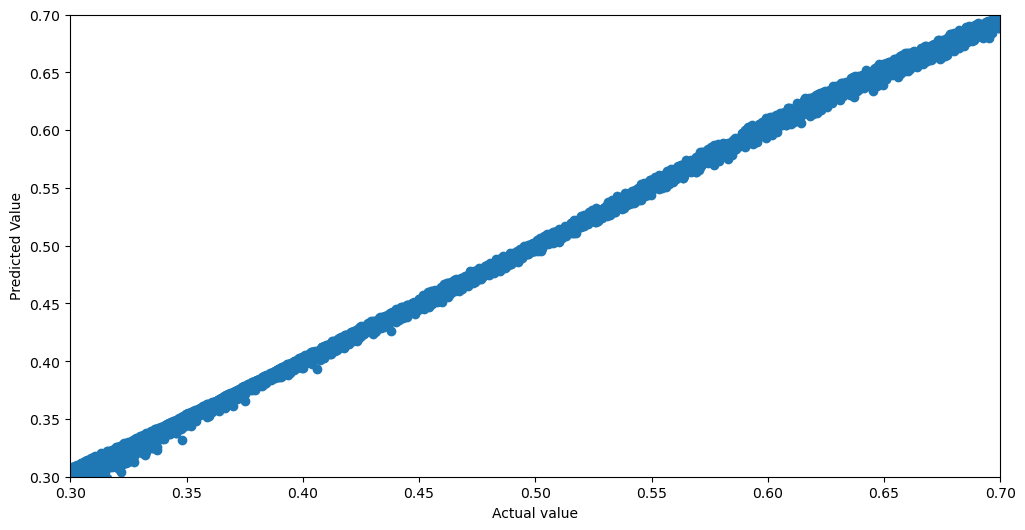

In [17]:
plt.scatter(Y1,test1_predictions)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show